In [2]:
import torch
import torchvision

from torch import nn
from torchsummary import summary
import torch.nn.functional as F
from torchvision import transforms

In [9]:
import numpy as np
import cv2
import os
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from pprint import pprint
import PIL

from paths import src_

In [7]:
class OmniglotSet(torch.utils.data.Dataset):
    
    def __init__(self,root_dir,setsize,transform,language=None):
        path = os.path.join(root_dir,'omniglot-py','images_background')
        print('choose the following language',os.listdir(path))
        
        self.root_dir = path
        self.language = language
        self.setsize = setsize
        self.transform = transform
        
    def __len__(self):
        return self.setsize
        
    def __getitem__(self,idx):
        language = os.listdir(self.root_dir)
        
        if self.language is None:
            language = np.random.choice(language)
        else:
            language = self.language
            
        lang_path = os.path.join(self.root_dir,language)
        char = os.listdir(lang_path)
        
        if idx % 2 == 0:
            char1 = np.random.choice(char)
            char2 = np.random.choice(char)
        else:
            char1 = np.random.choice(char)
            char2 = char1
        label = 1 if char1 == char2 else 0
        
        img1_path = np.random.choice(glob(os.path.join(lang_path,char1,'*')))
        img2_path = np.random.choice(glob(os.path.join(lang_path,char2,'*')))

        img1 = PIL.Image.open(img1_path)
        img2 = PIL.Image.open(img2_path)
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.Tensor([label])

In [8]:
class NwayKshotSet(torch.utils.data.Dataset):
    
    def __init__(self,root_dir,setsize,transform,language=None):
        path = os.path.join(root_dir,'omniglot-py','images_background')
        print('choose the following language',os.listdir(path))
        
        self.root_dir = path
        self.language = language
        self.setsize = setsize
        self.transform = transform
        
    def __len__(self):
        return self.setsize
        
    def __getitem__(self,idx):
        language = os.listdir(self.root_dir)
        
        if self.language is None:
            language = np.random.choice(language)
        else:
            language = self.language
            
        lang_path = os.path.join(self.root_dir,language)
        char = os.listdir(lang_path)
        
        querychar = np.random.choice(char)
        
        queryimg_path = np.random.choice(glob(os.path.join(lang_path,querychar,'*')))
        query = PIL.Image.open(queryimg_path)
        
        queryset = []
        for c in char:
            setimg_path = np.random.choice(glob(os.path.join(lang_path,c,'*')))
            setimg = PIL.Image.open(setimg_path)
            queryset.append(setimg)
        
        if self.transform:
            query = self.transform(query)
            queryset = [self.transform(s) for s in queryset]
                
        return query, queryset, torch.Tensor([char.index(querychar)])

In [10]:
dataset = OmniglotSet(src_ + '/data',1000,transforms.ToTensor(),language='Armenian')

choose the following language ['Mkhedruli_(Georgian)', 'Anglo-Saxon_Futhorc', 'Sanskrit', 'Japanese_(katakana)', 'Grantha', 'Japanese_(hiragana)', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'N_Ko', 'Burmese_(Myanmar)', 'Hebrew', 'Asomtavruli_(Georgian)', 'Balinese', 'Greek', 'Syriac_(Estrangelo)', 'Tifinagh', 'Early_Aramaic', 'Gujarati', 'Alphabet_of_the_Magi', 'Malay_(Jawi_-_Arabic)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Bengali', 'Tagalog', 'Armenian', 'Braille', 'Latin', 'Cyrillic', 'Blackfoot_(Canadian_Aboriginal_Syllabics)']


In [11]:
loader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True,num_workers=0)

  0%|          | 0/8 [00:00<?, ?it/s]

tensor([1.])


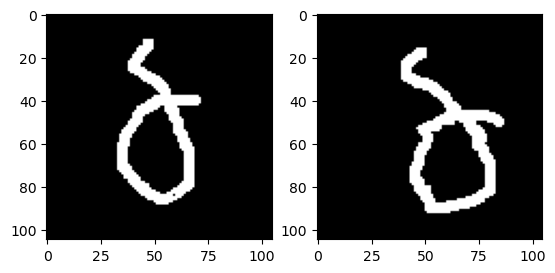

In [15]:
# 繪圖
for data in tqdm(loader):
    img1, img2, label = data
    img1, img2 = img1.numpy(), img2.numpy()
    img1, img2 = np.rollaxis(img1,1,4), np.rollaxis(img2,1,4)
    img1, img2 = np.squeeze(img1,3), np.squeeze(img2,3)

    plt.subplot(1,2,1)
    plt.imshow(img1[0], cmap='gray_r')
    plt.subplot(1,2,2)
    plt.imshow(img2[0], cmap='gray_r')
    print(label[0])
    break

In [16]:
classification_dataset = NwayKshotSet(src_ + '/data',1000,transforms.ToTensor(),language='Armenian')

choose the following language ['Mkhedruli_(Georgian)', 'Anglo-Saxon_Futhorc', 'Sanskrit', 'Japanese_(katakana)', 'Grantha', 'Japanese_(hiragana)', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'N_Ko', 'Burmese_(Myanmar)', 'Hebrew', 'Asomtavruli_(Georgian)', 'Balinese', 'Greek', 'Syriac_(Estrangelo)', 'Tifinagh', 'Early_Aramaic', 'Gujarati', 'Alphabet_of_the_Magi', 'Malay_(Jawi_-_Arabic)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Bengali', 'Tagalog', 'Armenian', 'Braille', 'Latin', 'Cyrillic', 'Blackfoot_(Canadian_Aboriginal_Syllabics)']


In [17]:
fewshotloader = torch.utils.data.DataLoader(classification_dataset,batch_size=32,shuffle=True,num_workers=0)

model

In [18]:
class net(nn.Module):
    
    def __init__(self):
        super(net,self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1,32,10),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(32,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(64,128,3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.clf = nn.Sequential(
            nn.Linear(9*9*128,256),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(256,1)
                
    def feature_extract(self,x):
        tmp = self.conv_1(x)
        tmp = self.conv_2(tmp)
        tmp = self.conv_3(tmp)
        tmp = tmp.view(-1,9*9*128)
        tmp = self.clf(tmp)
        
        return tmp
        
    def forward(self,x,y):
        tmp = self.feature_extract(x)

        tmp2 = self.feature_extract(y)
        
        tmp3 = torch.abs(tmp - tmp2)
                
        tmp3 = self.out(tmp3)
        
        return tmp3

In [19]:
model = net().cuda()

In [35]:
# summary(model,[(1,105,105),(1,105,105)])

In [20]:
# 檢查 forward
with torch.no_grad():
    model.eval()
    model(torch.randn(2,1,105,105).cuda(),torch.randn(2,1,105,105).cuda()).shape

training

In [21]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(),weight_decay=0.05)

In [22]:
epoch = 50

In [23]:
training_loss = []
model.train()
for e in range(epoch):
    runningLoss = 0.0
    for i, data in enumerate(tqdm(loader)):
        img, img2, label = data
        
        img = img.cuda()
        img2 = img2.cuda()
        label = label.cuda()
        
        output = model(img,img2)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optim.step()

        runningLoss += loss.item()
        
        img.detach().cpu()
        img2.detach().cpu()
        label.detach().cpu()
    print(f'epoch:{e+1}, loss: {runningLoss/len(dataset)}')
    training_loss.append(runningLoss/len(dataset))

100%|██████████| 8/8 [00:01<00:00,  6.77it/s]


epoch:1, loss: 0.005156160593032837


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


epoch:2, loss: 0.00477266925573349


100%|██████████| 8/8 [00:00<00:00, 20.02it/s]


epoch:3, loss: 0.004223446279764175


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


epoch:4, loss: 0.003670955300331116


100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


epoch:5, loss: 0.003771423399448395


100%|██████████| 8/8 [00:00<00:00, 20.15it/s]


epoch:6, loss: 0.0032627469897270204


100%|██████████| 8/8 [00:00<00:00, 20.07it/s]


epoch:7, loss: 0.0032619171142578124


100%|██████████| 8/8 [00:00<00:00, 20.15it/s]


epoch:8, loss: 0.0031859011352062226


100%|██████████| 8/8 [00:00<00:00, 20.16it/s]


epoch:9, loss: 0.0031218041479587556


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


epoch:10, loss: 0.0032513734102249145


100%|██████████| 8/8 [00:00<00:00, 20.20it/s]


epoch:11, loss: 0.003095020651817322


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


epoch:12, loss: 0.003378748446702957


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


epoch:13, loss: 0.0029706160128116607


100%|██████████| 8/8 [00:00<00:00, 20.06it/s]


epoch:14, loss: 0.0030500885844230653


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


epoch:15, loss: 0.0030882801711559294


100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


epoch:16, loss: 0.003192714482545853


100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


epoch:17, loss: 0.003332793086767197


100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


epoch:18, loss: 0.0030497705936431887


100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


epoch:19, loss: 0.0027257615327835084


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


epoch:20, loss: 0.0028518549501895907


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


epoch:21, loss: 0.003033201038837433


100%|██████████| 8/8 [00:00<00:00, 20.35it/s]


epoch:22, loss: 0.002984051376581192


100%|██████████| 8/8 [00:00<00:00, 20.25it/s]


epoch:23, loss: 0.0030607873499393463


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


epoch:24, loss: 0.00307121667265892


100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


epoch:25, loss: 0.002928541988134384


100%|██████████| 8/8 [00:00<00:00, 20.30it/s]


epoch:26, loss: 0.003072048872709274


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


epoch:27, loss: 0.0030260966420173644


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


epoch:28, loss: 0.0028472792208194733


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


epoch:29, loss: 0.002944171339273453


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


epoch:30, loss: 0.002906551033258438


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


epoch:31, loss: 0.002915627807378769


100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


epoch:32, loss: 0.002647988319396973


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


epoch:33, loss: 0.0028533860743045806


100%|██████████| 8/8 [00:00<00:00, 20.08it/s]


epoch:34, loss: 0.0027109156250953673


100%|██████████| 8/8 [00:00<00:00, 20.09it/s]


epoch:35, loss: 0.0025224673599004745


100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


epoch:36, loss: 0.002841278314590454


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


epoch:37, loss: 0.0026279527842998506


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


epoch:38, loss: 0.0025785576105117796


100%|██████████| 8/8 [00:00<00:00, 20.11it/s]


epoch:39, loss: 0.0026238901615142822


100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


epoch:40, loss: 0.002715015798807144


100%|██████████| 8/8 [00:00<00:00, 20.06it/s]


epoch:41, loss: 0.0025659819543361662


100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


epoch:42, loss: 0.0027617360651493073


100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


epoch:43, loss: 0.0026996581256389617


100%|██████████| 8/8 [00:00<00:00, 20.20it/s]


epoch:44, loss: 0.0025124329328536986


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


epoch:45, loss: 0.0024375195503234864


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


epoch:46, loss: 0.0026219570636749267


100%|██████████| 8/8 [00:00<00:00, 20.22it/s]


epoch:47, loss: 0.002276871740818024


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


epoch:48, loss: 0.002339453041553497


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


epoch:49, loss: 0.0023649631440639494


100%|██████████| 8/8 [00:00<00:00, 20.59it/s]

epoch:50, loss: 0.002725729823112488


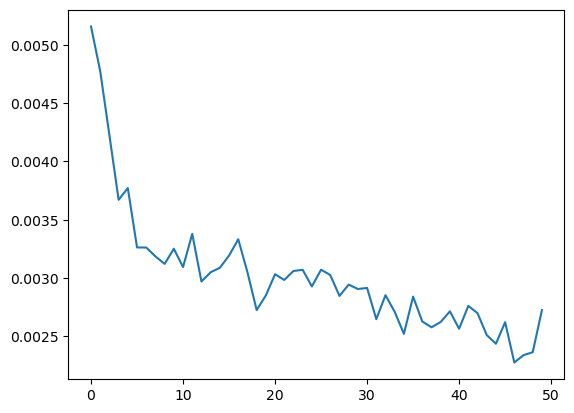

In [24]:
plt.plot(training_loss)

evaluation

In [25]:
count = 0
for data in tqdm(loader):
    img1, img2, label = data
    label = label.cuda()
    with torch.no_grad():
        model.eval()
        res = model(img1.cuda(),img2.cuda())
        res = torch.where(res.sigmoid()>=0.5,torch.ones_like(res),torch.zeros_like(res))
        count += torch.sum(res==label).item()
print('acc=',count/len(dataset))

100%|██████████| 8/8 [00:00<00:00, 24.54it/s]

acc= 0.83


In [26]:
count = 0
for data in tqdm(fewshotloader):
    q, s, label = data
    label = label.cuda().view(-1)
    with torch.no_grad():
        model.eval()
        res = [model(q.cuda(),s_img.cuda()) for s_img in s]
        res = torch.cat(res,dim=1).sigmoid().argmax(dim=1)
        count += torch.sum(res==label).item()
print('acc=',count/len(classification_dataset))

100%|██████████| 32/32 [00:05<00:00,  6.00it/s]

acc= 0.248


S & L

In [26]:
torch.save(model.state_dict(),'siamese.pth')

In [36]:
model.load_state_dict(torch.load('siamese.pth'))

<All keys matched successfully>

Visualization

In [27]:
embed = []
for data in tqdm(loader):
    img1,img2,label = data
    img1 = img1.cuda()
    output = model.feature_extract(img1)
    output = output.detach().cpu()
    img1 = img1.detach().cpu()
    embed.append(output)

100%|██████████| 8/8 [00:00<00:00, 29.53it/s]


In [29]:
from umap import UMAP

In [33]:
embed_model = UMAP()
embedding = embed_model.fit_transform(torch.cat(embed).numpy())

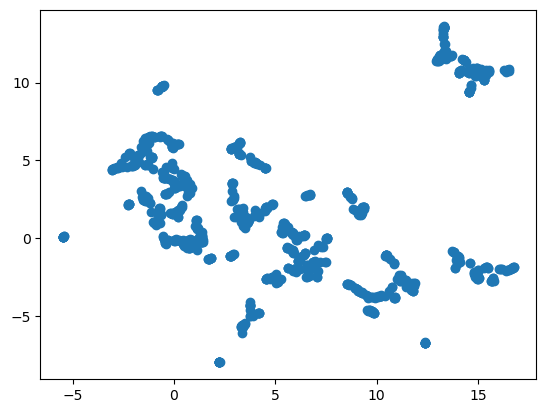

In [34]:
plt.scatter(embedding[:,0],embedding[:,1])